In [35]:
#adapted from http://mlbernauer.com/R/20160131-document-retrieval-sklearn.html

In [152]:
import os
import pandas as pd

import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.cluster import KMeans
from sklearn.externals import joblib

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns

import nltk
import nltk.data
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

import re
import string
import time
import codecs
from Bio import Medline

import gensim
from gensim import corpora, models, similarities
from collections import defaultdict

In [2]:
os.getcwd()

'/Users/ptighe/Documents/Python Projects/AcutePainOntology/medline_testing'

In [3]:
path='pubmed_result_medline.txt'

In [4]:
#Taken directly from reference:

In [5]:
#Dictionary of medline terms: https://www.nlm.nih.gov/bsd/mms/medlineelements.html
def read_medline_data(filename):
    recs = Medline.parse(open(filename, 'r'))
    text = pd.DataFrame(columns = ["pmid", "articletitle", "journaltitle", "authors", "affiliation", "grant",
                                   "abstract", "pubdate"])
    count = 0
    for rec in recs:
        try:
            abstr = rec["AB"]
            atitle = rec["TI"]
            auths = rec["AU"]
            pubdate = rec["DP"]
            jtitle = rec["JT"]
            grant=rec["GR"]
            pmid = rec['PMID']
            affil = rec['AD']
            text = text.append(pd.DataFrame([[pmid,atitle, jtitle, auths, affil,grant, abstr,pubdate]],
                                     columns=["pmid", "articletitle", "journaltitle", "authors", "affiliation", 
                                              "grant", "abstract", "pubdate"]),ignore_index=True)            
        except:
            pass
    return text

In [6]:
# Read in MEDLINE formatted text
papers = read_medline_data(path)

In [7]:
papers.loc[0,'abstract']

'BACKGROUND: Consensus indicates that a comprehensive,multimodal, holistic approach is foundational to the practice of acute pain medicine (APM),but lack of uniform, evidence-based clinical pathways leads to undesirable variability throughout U. S. healthcare systems. Acute pain studies are inconsistently synthesized to guide educational programs. Advanced practice techniques involving regional anesthesia assume the presence of a physician-led, multidisciplinary acute pain service,which is often unavailable or inconsistently applied.This heterogeneity of educational and organizational standards may result in unnecessary patient pain and escalation of healthcare costs. METHODS: A multidisciplinary panel was nominated through the APM Shared Interest Group of the American Academy of Pain Medicine. The panel met in Chicago, IL, in July 2014, to identify gaps and set priorities in APM research and education. RESULTS: The panel identified three areas of critical need: 1) an open-source acute

In [8]:
#Need to find a list of subheadings to remove?

shp = re.compile(r'^[A-Z\d]+$')

subheadings =[u"OBJECTIVES:", u"OBJECTIVE:", u"AIMS:", u"OBJECTIVE/BACKGROUND:",
              u"METHODS AND RESULTS:", u"CONCLUSIONS:", u"RESULTS:", u"METHODS:", u"INTRODUCTION:", u"BACKGROUND:"]

In [9]:
#Now some items for cleaning the abstract text
from nltk.corpus import stopwords
stoplist = stopwords.words('english')
stoplist.extend(['\x0c', '\n'])
subheadings =[u"OBJECTIVES:", u"OBJECTIVE:", u"AIMS:", u"OBJECTIVE/BACKGROUND:",
              u"METHODS AND RESULTS:", u"CONCLUSIONS:", u"RESULTS:", u"METHODS:", u"INTRODUCTION:", u"BACKGROUND:"]

In [10]:
papers['split_abstract'] = papers['abstract'].str.split()
papers['split_abstract'] = papers['split_abstract'].apply(lambda x: [item for item in x if item not in subheadings])
papers['split_abstract'] = papers['split_abstract'].apply(lambda x: ' '.join(x).lower().split())
papers['split_abstract'] = papers['split_abstract'].apply(lambda x: [item for item in x if item not in stoplist])

In [11]:
papers['cleaned_abstract']=papers['split_abstract'].apply(lambda x: ' '.join(x))
papers['cleaned_abstract']=papers['cleaned_abstract'].str.replace("[^a-zA-Z]"," ").str.replace("\s+"," ").str.strip()

In [12]:
papers['cleaned_abstract']

0     consensus indicates comprehensive multimodal h...
1     older adults increased risk develop frequent p...
2     prior work postoperative pain trajectories exa...
3     given ability process highly dimensional datas...
4     despite widespread popularity social media lit...
5     objective study determine effects age sex type...
6     prior work addressed sex differences incidence...
7     although prior work investigated interplay dem...
8     american academy pain medicine american societ...
9     goal project explore association post anesthes...
10    recent years field acute pain medicine apm wit...
11    purpose project determine whether machine lear...
12    although million patients united states underg...
Name: cleaned_abstract, dtype: object

In [13]:
papers['split_articletitle'] = papers['articletitle'].str.split()
papers['split_articletitle'] = papers['split_articletitle'].apply(lambda x: ' '.join(x).lower().split())
papers['split_articletitle'] = papers['split_articletitle'].apply(lambda x: [item for item in x if item not in stoplist])
papers['cleaned_articletitle']=papers['split_articletitle'].apply(lambda x: ' '.join(x))
papers['cleaned_articletitle']=papers['cleaned_articletitle'].str.replace("[^a-zA-Z]"," ").str.replace("\s\s+"," ")

In [14]:
papers['cleaned_articletitle']

0      acute pain medicine united states status report 
1     age differences cytokine expression conditions...
2     time onset sustained postoperative pain relief...
3     teaching machine feel postoperative pain combi...
4     painful tweet text sentiment community structu...
5     clinically derived early postoperative pain tr...
6     sex differences incidence severe pain events f...
7     geospatial analysis hospital consumer assessme...
8                   acute pain medicine anesthesiology 
9     rough starts smooth finishes correlations post...
10              evolution practice acute pain medicine 
11    use machine learning classifiers predict reque...
12    primary payer status associated use nerve bloc...
Name: cleaned_articletitle, dtype: object

In [15]:
papers['ca_tokens'] =papers['cleaned_abstract'].map(lambda text: nltk.tokenize.word_tokenize(text))
papers['ra_tokens'] =papers['abstract'].map(lambda text: nltk.tokenize.word_tokenize(text))
papers['ra_tokens']


0     [BACKGROUND, :, Consensus, indicates, that, a,...
1     [Older, adults, are, at, an, increased, risk, ...
2     [OBJECTIVES, :, Prior, work, on, postoperative...
3     [BACKGROUND, :, Given, their, ability, to, pro...
4     [BACKGROUND, :, Despite, the, widespread, popu...
5     [The, objective, of, this, study, was, to, det...
6     [OBJECTIVE/BACKGROUND, :, Prior, work, has, no...
7     [Although, prior, work, has, investigated, the...
8     [The, American, Academy, of, Pain, Medicine, a...
9     [OBJECTIVE, :, The, goal, of, this, project, w...
10    [BACKGROUND, :, In, recent, years, ,, the, fie...
11    [OBJECTIVE, :, The, purpose, of, this, project...
12    [INTRODUCTION, :, Although, more, than, 30, mi...
Name: ra_tokens, dtype: object

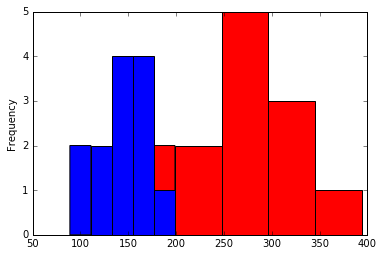

In [16]:
#These give token counts
papers['rabs_length'] =papers['ra_tokens'].map(lambda text: len(text))
papers['cabs_length'] =papers['ca_tokens'].map(lambda text: len(text))
papers.rabs_length.plot(bins=5, kind='hist', color='r')
papers.cabs_length.plot(bins=5, kind='hist')

In [17]:
papers['cabs_u_length'] =papers['ca_tokens'].map(lambda text: len(set(text)))
papers['cabs_u_length']

0     137
1      83
2      88
3      90
4     101
5      95
6      96
7      94
8      68
9      91
10     83
11    105
12    109
Name: cabs_u_length, dtype: int64

In [18]:
fd = papers['ca_tokens'].map(lambda text: nltk.FreqDist(text))


## Identify the most common terms in the cleaned abstract using the ca_tdm


In [121]:
#Word counts and such using CountVectorizer from https://www.kaggle.com/c/word2vec-nlp-tutorial/details/part-1-for-beginners-bag-of-words

cvec = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 100000,\
                              ngram_range=(1,3)) 

In [122]:
train_data_features = cvec.fit_transform(papers['cleaned_abstract'])
train_data_features = train_data_features.toarray()
print ('The nuts of bolts of the CountVectorizer is: ',cvec,'\n')
print ('The shape of the CountVectorizer array is:', train_data_features.shape,'\n')

The nuts of bolts of the CountVectorizer is:  CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=100000, min_df=1,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None) 

The shape of the CountVectorizer array is: (13, 4089) 



In [124]:
ca_tdm = pd.DataFrame(cvec.fit_transform(papers.cleaned_abstract).toarray(),columns=cvec.get_feature_names())
ca_tdm

,ability,ability forecast,ability forecast moderate,ability inability,ability inability classify,ability process,ability process highly,absolute,absolute shrinkage,absolute shrinkage selection,...,yielded highest area,yielded odds,yielded odds ratio,younger,younger individuals,younger individuals study,younger older,younger older healthy,younger patients,younger patients pain
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,1,1,1,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,1,1,0,0,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,1
6,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [125]:
#Identify the most common terms for each document via CountVectorizer
ca_tdm.idxmax(axis=1) #change to axis=0 will change the document wigh highest countb of each word

0            pain
1              il
2           suppr
3            pain
4            pain
5            pain
6            pain
7       hospitals
8            pain
9            pain
10           pain
11    classifiers
12          nerve
dtype: object

## Plot the most common terms in the cleaned abstract

Here is a list of the most common terms across all documents:  
 pain                           91
scores                         28
surgery                        25
patients                       23
pain scores                    21
suppr                          20
acute                          19
postoperative                  18
acute pain                     17
using                          15
time                           15
surgical                       14
postoperative pain             13
study                          13
ci                             12
apm                            12
data                           11
clinical                       10
nerve                          10
block                           9
machine                         9
classifiers                     9
median                          9
hour                            9
nerve block                     9
pain score                      8
well                            8
machine learning 

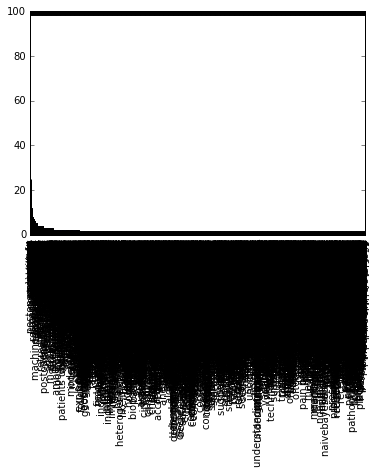

In [126]:
#Identify and visualize the most common terms across all documents
s=ca_tdm.sum().sort_values(ascending=False)
print('Here is a list of the most common terms across all documents: ','\n',s)
s.plot(kind='bar')

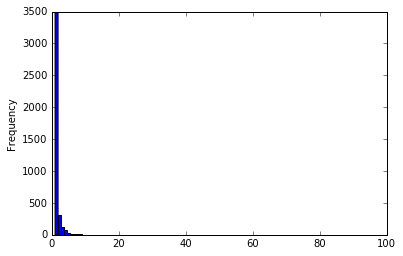

In [127]:
s.plot(kind='hist', bins=100)

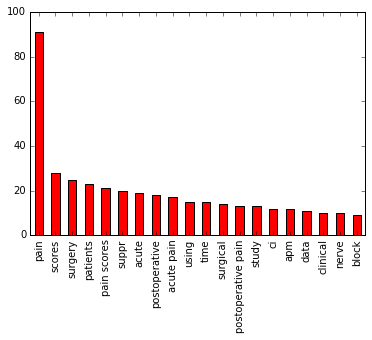

In [129]:
s[0:20].plot(kind='bar', color='r')

### Create TF-IDF for Abstracts

In [169]:
tvec = TfidfVectorizer(analyzer='word',
#                         max_df = 1, min_df=1,
                        max_features=100000,
#                       stopwords='none',
                        use_idf=True,
                        ngram_range=(1,3))

In [170]:
%time ca_tfidfm = tvec.fit_transform(papers['cleaned_abstract'])
print ('Shape of Cleaned Abstract TF-IDF Matrix: ',ca_tfidfm.shape)

CPU times: user 12.3 ms, sys: 926 µs, total: 13.3 ms
Wall time: 12.8 ms
Shape of Cleaned Abstract TF-IDF Matrix:  (13, 4089)


In [171]:
terms = tvec.get_feature_names()
terms[0:9]

['ability',
 'ability forecast',
 'ability forecast moderate',
 'ability inability',
 'ability inability classify',
 'ability process',
 'ability process highly',
 'absolute',
 'absolute shrinkage']

Axes(0.125,0.125;0.62x0.775)
[[ 1.          0.0265297   0.02298372  0.02423025  0.01912895  0.03403391
   0.0328558   0.03008152  0.14475193  0.02869678  0.13623416  0.01349563
   0.01518547]
 [ 0.0265297   1.          0.01904787  0.01700696  0.03268991  0.03353664
   0.03203415  0.01470781  0.02490685  0.0309471   0.03134195  0.00860257
   0.0040372 ]
 [ 0.02298372  0.01904787  1.          0.03579251  0.03000482  0.10244059
   0.06875525  0.02700226  0.02435316  0.07698471  0.01865076  0.01618202
   0.02720812]
 [ 0.02423025  0.01700696  0.03579251  1.          0.0235547   0.06001014
   0.08962613  0.02289133  0.0228021   0.02912173  0.01884779  0.10411003
   0.00790088]
 [ 0.01912895  0.03268991  0.03000482  0.0235547   1.          0.02907373
   0.03562351  0.03967194  0.02961325  0.04027147  0.04239958  0.00610489
   0.00899187]
 [ 0.03403391  0.03353664  0.10244059  0.06001014  0.02907373  1.
   0.14108849  0.02885941  0.0280134   0.10622748  0.02677072  0.03223292
   0.07426625]
 

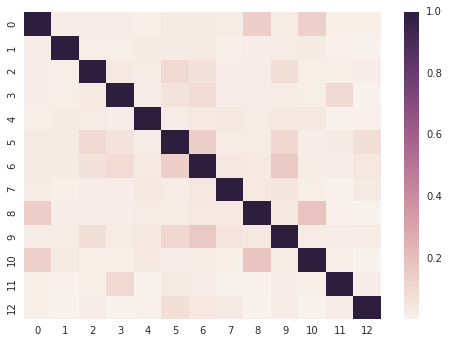

In [172]:
ca_tfidf_cos = cosine_similarity(ca_tfidfm)
print (sns.heatmap(ca_tfidf_cos))
print (ca_tfidf_cos)

### Future Planned projects:

1. Document clustering for Abstracts
2. Visualize document clusters for abstracts
3. LDA to identify topic models via GenSim
4. word2vec for pain related terms

999. Then do all this for the titles


Can start to use this template: http://brandonrose.org/clustering
